# **Movie recommendation**
## NTDS Project
### Author: *Qiao Qianqian*  / *Luo Yaxiong*  / *Deng Wenlong* / *Wang Pei*

___
This notebook is to design a system for recommendation of movies. 


### Dataset Information

___
We make recommendations using the content of the TMDB dataset that contains around 45,000 movies listed in the Full MovieLens Dataset. The dataset consists of movies released on or before July 2017. Data points include cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages. 

### System Mechanism
___
In practice, recommendation engines are of three kinds:
- **popularity-based** engines: usually the most simple to implement be also the most impersonal
- **content-based** engines: the recommendations are based on the description of the products
- **collaborative filtering** engines: records from various users provide recommendations based on user similarities

___ 
We aimed to model an engine for recommendation of movies based on several aspects such as popularity, similarity. We would like to find similar items by using a similarity metric. Once we have the matrix, we use it to determine the best recommendations for a user based on the movies he has already liked and watched. In other words, our engine bases on popularity and content.

### Recommendation Process

___
Basically,our system will work as follows: after the user has provided the name of a film he liked, the engine should be able to select in the database a list of 5 films that the user will enjoy. These files contain metadata for all 45,000 movies.

### The Organization

___
This notebook is organized as follows:

**1. Data Acquisition**
- 1.1 Keywords
- 1.2 Missing values
- 1.3 Number of films per year
- 1.4 Genres
- 1.5 Actors

** 2. Data Explpration**
- 2.1 Cleaning of the keywords
    * 2.1.1 Grouping by roots
    * 2.1.2 Groups of synonyms
    * 2.1.2 Groups of word vector
- 2.2 Actor Relations
    * 2.2.1 Actor with genres preference
    * 2.2.2 Actor distance
- 2.3 Correlations
- 2.4 Missing values
    * 2.4.1 Setting missing title years
    * 2.4.2 Extracting keywords from the title
    * 2.4.3 Imputing from regressions
- 2.5 Movies clustering
    
**3. Recommendation Engine Based on Movie**
- 3.1 Basic functioning of the engine 
    * 3.1.1 Similarity
    * 3.1.2 Popularity
- 3.2 Definition of the recommendation engine functions
- 3.3 Making meaningfull recommendations
- 3.4 Exemple of recommendation: test-case

**4. Recommendation Engine Based on User**
- 4.1 Basic functioning of the engine 
- 4.2 Definition of the engine functions
- 4.3 Making meaningfull recommendations

**5. Conclusion**


___
## 1. Data Acquisition

 First, we define a few functions to create an interface with the new structure of the dataset. Because the original dataset organize data in a complex way, we must extract useful data from the original. This stage also cleans the data briefly.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import math, nltk, warnings
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
import scipy.sparse.csgraph
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS
import spacy

nlp = spacy.load('en')
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings('ignore')
PS = nltk.stem.PorterStemmer()


#### Load the dataset.  
___
We use three packages which contain different information about the same movies. In recommendation stages, we will then load $rating.csv$ to make recommendations according to users.

In [2]:
def load_credits(path):
    df = pd.read_csv(path)
    return df
def load_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date'],errors='coerce').apply(lambda x: x.date())
    return df
def load_keywords(path):
    df = pd.read_csv(path)
    return df

In [3]:
# load the dataset
credits = load_credits("../data/credits.csv")
movies = load_movies("../data/movies_metadata.csv")
keywords = load_keywords("../data/keywords.csv")

You can see the data in original dataset. We aim at extract useful information from them.

In [4]:
credits.iloc[:5]

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [5]:
# Function for getting strings of keywords and genres and connecting them by "|"
def get_str(series, index_values):
    # return missing value rather than an error upon indexing/key failure
    try:
        idx = ast.literal_eval(series)
        if type(idx)== bool or type(idx) != list:
            values=[]
        else:
            values ='|'.join(str(x[index_values]) for x in idx)
    except ValueError or TypeError:
        values = []
    return values

In [6]:
# Function for getting values
# series:        df.series
# index_values:  Column name
# index:         return which one
def get_value(series,index_values,index):
    try:
        list_t = ast.literal_eval(series)
        if list_t:
            length = len(list_t)
            if index > length:
                values = pd.np.nan
            else:
                values =list_t[index-1][index_values]
        else:
            values= pd.np.nan
    except ValueError or TypeError:
        values = pd.np.nan
    return values


def get_director(crew_data,index_values):
    crew_data = ast.literal_eval(crew_data)
    for x in crew_data:
        if x['job'] == 'Director':
            return x[index_values]
        else:
            return pd.np.nan

In [7]:
def convert_to_easy(movies, credits, keywords):
    temp_movies = movies.copy(deep=True)
    temp_movies['title_year'] = pd.to_datetime(temp_movies['release_date'],errors='coerce').apply(lambda x: x.year)
    temp_movies['production_company_id'] = temp_movies['production_companies'].apply(lambda x: get_value(x, 'id',1))
    
    # Crew information
    temp_movies['director_id'] = credits['crew'].apply(lambda x: get_director(x,'id')) 
    temp_movies['director'] = credits['crew'].apply(lambda x: get_director(x,'name'))
    temp_movies['actor_id_1'] = credits['cast'].apply(lambda x: get_value(x, 'id',1))
    temp_movies['actor_name_1'] = credits['cast'].apply(lambda x: get_value(x,'name',1))
    temp_movies['actor_id_2'] = credits['cast'].apply(lambda x: get_value(x, 'id',2))
    temp_movies['actor_name_2'] = credits['cast'].apply(lambda x: get_value(x,'name',2))
    temp_movies['actor_id_3'] = credits['cast'].apply(lambda x: get_value(x, 'id',3))
    temp_movies['actor_name_3'] = credits['cast'].apply(lambda x: get_value(x,'name',3)) 
    
    # Content information
    temp_movies['keywords'] = keywords['keywords'].apply(lambda x: get_str(x,'name'))
    temp_movies['genres_id'] = temp_movies['genres'].apply(lambda x: get_value(x, 'id',1))
    temp_movies['genres'] = temp_movies['genres'].apply(lambda x: get_str(x,'name'))
    
    # Movie information
    temp_movies['country'] = temp_movies['production_countries'].apply(lambda x: get_str(x, 'name'))
    temp_movies['language'] = temp_movies['spoken_languages'].apply(lambda x: get_str(x, 'name'))
    temp_movies['production_company'] = temp_movies['production_companies'].apply(lambda x: get_str(x, 'name'))
    del temp_movies['tagline']
    del temp_movies['homepage']
    return temp_movies


___
From the loaded data, we use the function to convert those data in a clear layout.

In [8]:
df_original = convert_to_easy(movies, credits, keywords)

In [9]:
df_original.iloc[:5]

,adult,belongs_to_collection,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count,title_year,production_company_id,director_id,director,actor_id_1,actor_name_1,actor_id_2,actor_name_2,actor_id_3,actor_name_3,keywords,genres_id,country,language,production_company
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,Animation|Comedy|Family,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,False,7.7,5415.0,1995.0,3.0,7879.0,John Lasseter,31.0,Tom Hanks,12898.0,Tim Allen,7167.0,Don Rickles,jealousy|toy|boy|friendship|friends|rivalry|bo...,16.0,United States of America,English,Pixar Animation Studios
1,False,NaN,65000000,Adventure|Fantasy|Family,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,False,6.9,2413.0,1995.0,559.0,NaN,NaN,2157.0,Robin Williams,8537.0,Jonathan Hyde,205.0,Kirsten Dunst,board game|disappearance|based on children's b...,12.0,United States of America,English|Français,TriStar Pictures|Teitler Film|Interscope Commu...
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,Romance|Comedy,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grumpier Old Men,False,6.5,92.0,1995.0,6194.0,26502.0,Howard Deutch,6837.0,Walter Matthau,3151.0,Jack Lemmon,13567.0,Ann-Margret,fishing|best friend|duringcreditsstinger|old men,10749.0,United States of America,English,Warner Bros.|Lancaster Gate
3,False,NaN,16000000,Comedy|Drama|Romance,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Waiting to Exhale,False,6.1,34.0,1995.0,306.0,2178.0,Forest Whitaker,8851.0,Whitney Houston,9780.0,Angela Bassett,18284.0,Loretta Devine,based on novel|interracial relationship|single...,35.0,United States of America,English,Twentieth Century Fox Film Corporation
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,Comedy,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Father of the Bride Part II,False,5.7,173.0,1995.0,5842.0,NaN,NaN,67773.0,Steve Martin,3092.0,Diane Keaton,519.0,Martin Short,baby|midlife crisis|confidence|aging|daughter|...,35.0,United States of America,English,Sandollar Productions|Touchstone Pictures


#### Delete useless columns
There are too many columns we will delete some. Because we have used the information from the original dataset, we now delete the repeated and useless columns.

In [10]:
# df     : dataframe
# columns: name of removed columns
def delete_column(df,columns):
    df_new = df.copy(deep=True)
    delete = columns
    for i in delete:
        if i in df_new.columns:
            
            del df_new[i]
        else:
            print('There is no column named '+ str(i) +' in original dataframe')
    return df_new

In [11]:
col = ['adult','belongs_to_collection','imdb_id',
        'original_language','original_title','poster_path','production_companies',
        'production_countries','spoken_languages','status','video']
df_initial = delete_column(df_original,col)

In [12]:
print('Shape:',df_initial.shape)
# info on variable types and filling factor
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
tab_info

Shape: (45466, 26)


,budget,genres,id,overview,popularity,release_date,revenue,runtime,title,vote_average,vote_count,title_year,production_company_id,director_id,director,actor_id_1,actor_name_1,actor_id_2,actor_name_2,actor_id_3,actor_name_3,keywords,genres_id,country,language,production_company
column type,object,object,object,object,object,object,float64,float64,object,float64,float64,float64,float64,float64,object,float64,object,float64,object,float64,object,object,float64,object,object,object
null values,0,0,0,954,5,90,6,263,6,6,6,90,11881,19941,19941,2417,2417,3749,3749,4659,4659,0,2442,0,0,0
null values (%),0,0,0,2.09827,0.0109972,0.19795,0.0131967,0.578454,0.0131967,0.0131967,0.0131967,0.19795,26.1316,43.8591,43.8591,5.31606,5.31606,8.24572,8.24572,10.2472,10.2472,0,5.37105,0,0,0


Now we have reached the clear dataframe. 

In [13]:
df_initial.head(5)

,budget,genres,id,overview,popularity,release_date,revenue,runtime,title,vote_average,vote_count,title_year,production_company_id,director_id,director,actor_id_1,actor_name_1,actor_id_2,actor_name_2,actor_id_3,actor_name_3,keywords,genres_id,country,language,production_company
0,30000000,Animation|Comedy|Family,862,"Led by Woody, Andy's toys live happily in his ...",21.9469,1995-10-30,373554033.0,81.0,Toy Story,7.7,5415.0,1995.0,3.0,7879.0,John Lasseter,31.0,Tom Hanks,12898.0,Tim Allen,7167.0,Don Rickles,jealousy|toy|boy|friendship|friends|rivalry|bo...,16.0,United States of America,English,Pixar Animation Studios
1,65000000,Adventure|Fantasy|Family,8844,When siblings Judy and Peter discover an encha...,17.0155,1995-12-15,262797249.0,104.0,Jumanji,6.9,2413.0,1995.0,559.0,NaN,NaN,2157.0,Robin Williams,8537.0,Jonathan Hyde,205.0,Kirsten Dunst,board game|disappearance|based on children's b...,12.0,United States of America,English|Français,TriStar Pictures|Teitler Film|Interscope Commu...
2,0,Romance|Comedy,15602,A family wedding reignites the ancient feud be...,11.7129,1995-12-22,0.0,101.0,Grumpier Old Men,6.5,92.0,1995.0,6194.0,26502.0,Howard Deutch,6837.0,Walter Matthau,3151.0,Jack Lemmon,13567.0,Ann-Margret,fishing|best friend|duringcreditsstinger|old men,10749.0,United States of America,English,Warner Bros.|Lancaster Gate
3,16000000,Comedy|Drama|Romance,31357,"Cheated on, mistreated and stepped on, the wom...",3.85949,1995-12-22,81452156.0,127.0,Waiting to Exhale,6.1,34.0,1995.0,306.0,2178.0,Forest Whitaker,8851.0,Whitney Houston,9780.0,Angela Bassett,18284.0,Loretta Devine,based on novel|interracial relationship|single...,35.0,United States of America,English,Twentieth Century Fox Film Corporation
4,0,Comedy,11862,Just when George Banks has recovered from his ...,8.38752,1995-02-10,76578911.0,106.0,Father of the Bride Part II,5.7,173.0,1995.0,5842.0,NaN,NaN,67773.0,Steve Martin,3092.0,Diane Keaton,519.0,Martin Short,baby|midlife crisis|confidence|aging|daughter|...,35.0,United States of America,English,Sandollar Productions|Touchstone Pictures


___
### 1.1 Keywords

We plan to make an extensive use of the keywords that describe the movies. Indeed, a basic assumption is that films described by similar keywords should have similar contents. Hence, we will have a close look at the way keywords are defined and as a first step.

We define a function to calculate the frequency of content and return an ordered list.


Note that this function will be used again in other sections of this notebook, when exploring the content of the *'genres'* variable and subsequently, when cleaning the keywords. Finally, calling this function gives access to a list of keywords which are sorted by decreasing frequency:

In [14]:
def count_word(df, column, list_obj, type_store):
    
    # If the type you need count is str with |, type_score = 2
    # If the type is others, just type_score = 1
    keyword_count = dict()
    for s in list_obj: keyword_count[s] = 0
        
    if type_store == 1:
        set_temp = df[column].str.split('|')
    elif type_store == 2:
        set_temp = df[column]
        
    for list_keywords in set_temp:
        if type(list_keywords) == float and pd.isnull(list_keywords): continue # judge if this set is validaty     
        for s in [s for s in list_keywords if s in list_obj]: 
            if pd.notnull(s): keyword_count[s] += 1 
                
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    # keyword_count is a dictionary and keyword_occurences is sorted list [].
    return keyword_occurences, keyword_count

Use the set to get the keywords set and then calculate the frequency

In [15]:
# keep the original keywords set
set_keywords_0 = set()
for list_keywords in df_initial['keywords'].str.split('|').values:
    if isinstance(list_keywords, float): continue  # only happen if liste_keywords = NaN
    set_keywords_0 = set_keywords_0.union(list_keywords)
    
# remove null chain entry
set_keywords_0.remove('')

In [16]:
keyword_occurences_0, dum = count_word(df_initial, 'keywords', set_keywords_0,1)
keyword_occurences_0[-20:]

[['past prime', 1],
 ['weapons history', 1],
 ['flute', 1],
 ['buried', 1],
 ['hamburgers', 1],
 ['team roping', 1],
 ['car seat', 1],
 ['head nurse', 1],
 ['better life', 1],
 ['simpler life', 1],
 ['woman journalist', 1],
 ['history of film', 1],
 ['thompson sub machine gun', 1],
 ['murderous pair', 1],
 ['fifth arrondissement of paris toilet', 1],
 ['cool hair', 1],
 ['guinevere', 1],
 ['herbicide', 1],
 ['british fleet', 1],
 ['half naked man', 1]]

You can see there are many keywords appearing only once. We plan to set a threshold for keeping "more" important keywords.

#### 1.1.2 Cleaning Keywords
We can see there are many keywords whose occurences are 1. We try to delete them.


In [17]:
# Delete the low-frequency elements
# df:           the original dataframe
# column:       which column you want to change
# replacement:  the few keywords set
def delete_few(df,column,few_set):
    df_new = df.copy(deep = True)
    for index, row in df_new.iterrows():
        chaine = row[column]
        if pd.isnull(chaine): continue
        nouvelle_liste = []
        for s in chaine.split('|'): 
            if s not in few_set:
                nouvelle_liste.append(s) 
        df_new.set_value(index, column, '|'.join(nouvelle_liste)) 
    return df_new

Delete the frequency 1 keywords.

In [18]:
keyword_few = [i[0] for i in keyword_occurences_0 if i[1]<2]
len(keyword_few)

8521

In [19]:
df_initial = delete_few(df_initial,'keywords',keyword_few)

Calculate the new set of keywords, in which we only keep keywords appeared more times.

In [20]:
set_keywords = set()
for list_keywords in df_initial['keywords'].str.split('|').values:
    if isinstance(list_keywords, float): continue  # only happen if liste_keywords = NaN
    set_keywords = set_keywords.union(list_keywords)
set_keywords.remove('')

In [21]:
keyword_occurences, dum = count_word(df_initial, 'keywords', set_keywords,1)
keyword_occurences[-5:]

[['scary', 2],
 ['naval combat', 2],
 ['trapdoor', 2],
 ['labor day', 2],
 ['shot in the throat', 2]]

In [22]:
len(keyword_occurences)

11320

However, there are still 11320 keywords. Later, in data exploration, we plan to decrease the keywords by different aspects like meaning.

At this stage, the list of keywords has been created and we know the number of times each of them appear in the dataset. In fact, this list can be used to have a feeling of the content of the *most popular movies*. A fancy manner to give that information makes use of the *wordcloud* package. All the words are arranged in a figure with sizes that depend on their respective frequencies. 

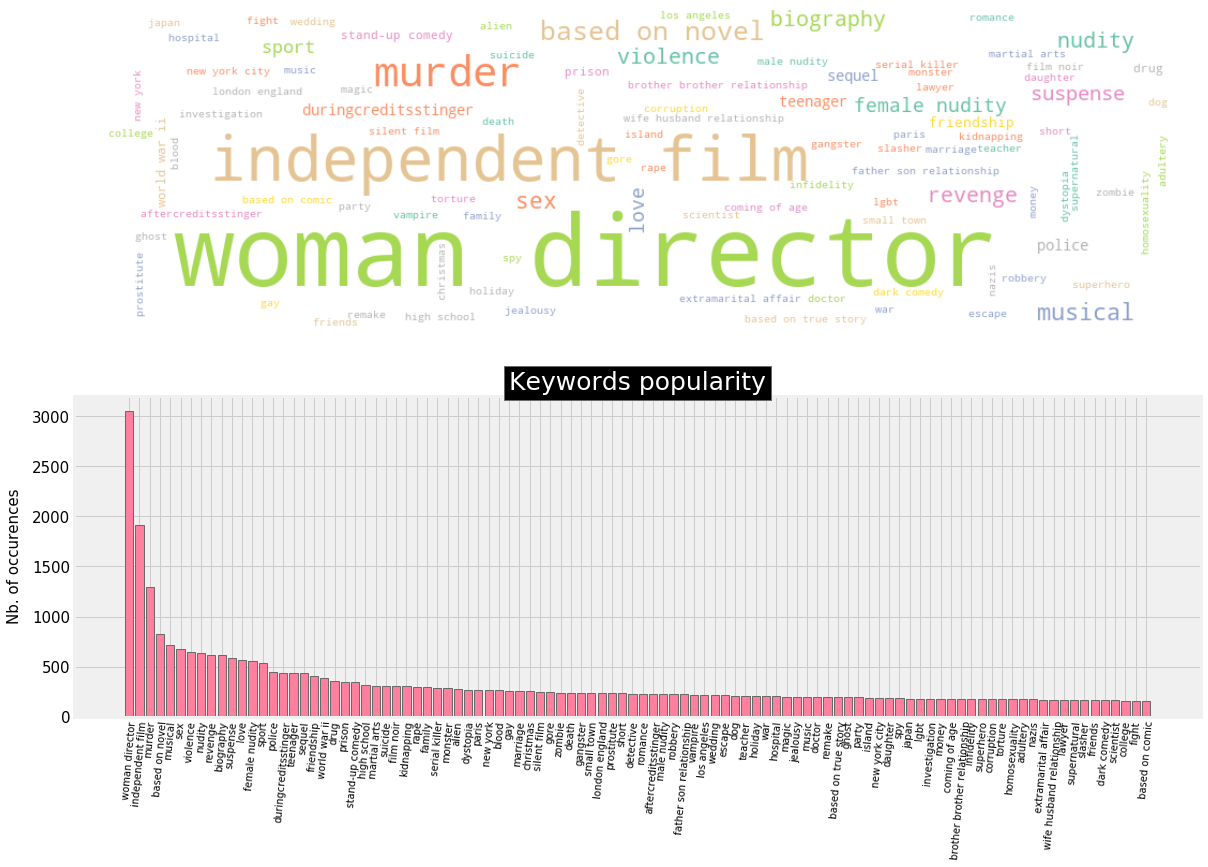

In [23]:
fig = plt.figure(1, figsize=(18,13))
ax1 = fig.add_subplot(2,1,1)

words = dict()
trunc_occurences = keyword_occurences[0:100]
for s in trunc_occurences:
    words[s[0]] = s[1]

wordcloud = WordCloud(width=1000,height=300, background_color='white', 
                      max_words=1628,relative_scaling=1,
                      colormap="Set2_r",
                      normalize_plurals = False)
wordcloud.generate_from_frequencies(words)
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off')

# LOWER PANEL: HISTOGRAMS
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 10)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Nb. of occurences", fontsize = 15, labelpad = 10)
ax2.bar(x_axis, y_axis, align = 'center', color=(1.0,0.5,0.62))
#_______________________
plt.title("Keywords popularity",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 25)
plt.show()

We can see people pay much attention to the gender of the director. 

___
### 1.2 Filling factor: missing values

As in every analysis, at some point, we will have to deal with the missing values and as a first step, we determine the amount of data which is missing in every variable:

In [24]:
missing_df = df_initial.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df_initial.shape[0] - missing_df['missing_count']) / df_initial.shape[0] * 100
missing_df.sort_values('filling_factor').reset_index(drop = True)

,column_name,missing_count,filling_factor
0,director,19941,56.140853
1,director_id,19941,56.140853
2,production_company_id,11881,73.868385
3,actor_id_3,4659,89.752782
4,actor_name_3,4659,89.752782
5,actor_id_2,3749,91.754278
6,actor_name_2,3749,91.754278
7,genres_id,2442,94.628954
8,actor_id_1,2417,94.683940
9,actor_name_1,2417,94.683940


We can see that most of the variables are well filled since 9 of them have a filling factor below 93%.

___
### 1.3 Number of films per year

The **title_year** variable indicates when films were released. 

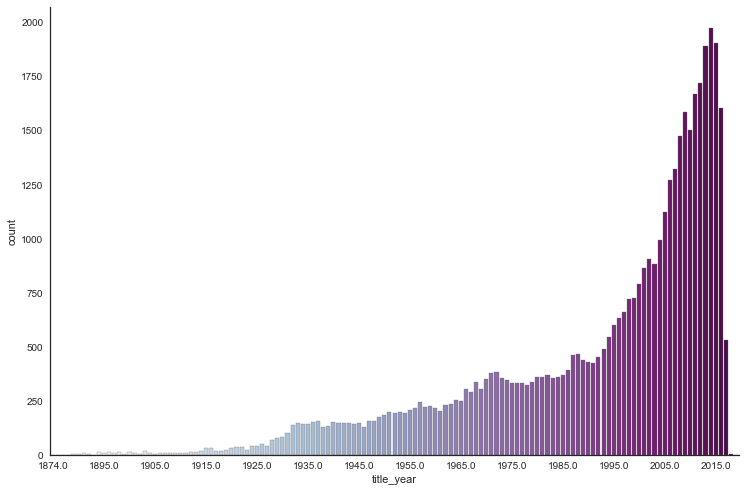

In [25]:
sns.set(style="white")
# Draw a count plot to show the number of movies each year
g = sns.factorplot(x="title_year", data=df_initial, kind="count",palette="BuPu", size=7, aspect=1.5)
g.set_xticklabels(step=10)

The number of films increases with years. There is a peak at year 2013.

___
### 1.4 Genres

The **genres** will surely be important while building the recommendation system based on content since it describes the content of the film (i.e. Drama, Comedy, Action, ...). To see exactly which genres are the most popular, we use the same approach applied in keywords.

Like the keywords, we still get the original set of genres.

In [26]:
set_genre_0 = set()
for s in df_initial['genres'].str.split('|').values:
    set_genre_0 = set_genre_0.union(set(s))

and then counting how many times each of them occur:

In [27]:
genre_occurences_0, genre_dum = count_word(df_initial, 'genres', set_genre_0,1)
genre_occurences_0

[['Drama', 20265],
 ['Comedy', 13182],
 ['Thriller', 7624],
 ['Romance', 6735],
 ['Action', 6596],
 ['Horror', 4673],
 ['Crime', 4307],
 ['Documentary', 3932],
 ['Adventure', 3496],
 ['Science Fiction', 3049],
 ['Family', 2770],
 ['Mystery', 2467],
 ['', 2442],
 ['Fantasy', 2313],
 ['Animation', 1935],
 ['Foreign', 1622],
 ['Music', 1598],
 ['History', 1398],
 ['War', 1323],
 ['Western', 1042],
 ['TV Movie', 767],
 ['Pulser Productions', 1],
 ['GoHands', 1],
 ['Mardock Scramble Production Committee', 1],
 ['BROSTA TV', 1],
 ['Aniplex', 1],
 ['Carousel Productions', 1],
 ['The Cartel', 1],
 ['Telescene Film Group Productions', 1],
 ['Sentai Filmworks', 1],
 ['Rogue State', 1],
 ['Vision View Entertainment', 1],
 ['Odyssey Media', 1]]

We would like to remove the genres which appear few times.

In [28]:
genre_few = [i[0] for i in genre_occurences_0 if i[1]<10]
len(genre_few)
df_initial = delete_few(df_initial,'genres',genre_few)

Re-calculate the set of genre

In [29]:
set_genre = set()
for s in df_initial['genres'].str.split('|').values:
    set_genre = set_genre.union(set(s))
set_genre.remove('')

In [30]:
genre_occurences, genre_dum = count_word(df_initial, 'genres', set_genre,1)
genre_occurences

[['Drama', 20265],
 ['Comedy', 13182],
 ['Thriller', 7624],
 ['Romance', 6735],
 ['Action', 6596],
 ['Horror', 4673],
 ['Crime', 4307],
 ['Documentary', 3932],
 ['Adventure', 3496],
 ['Science Fiction', 3049],
 ['Family', 2770],
 ['Mystery', 2467],
 ['Fantasy', 2313],
 ['Animation', 1935],
 ['Foreign', 1622],
 ['Music', 1598],
 ['History', 1398],
 ['War', 1323],
 ['Western', 1042],
 ['TV Movie', 767]]

In [31]:
len(genre_occurences)

20

Now we only have 20 genres in our dataframe.
Finally, the result is shown as a wordcloud:

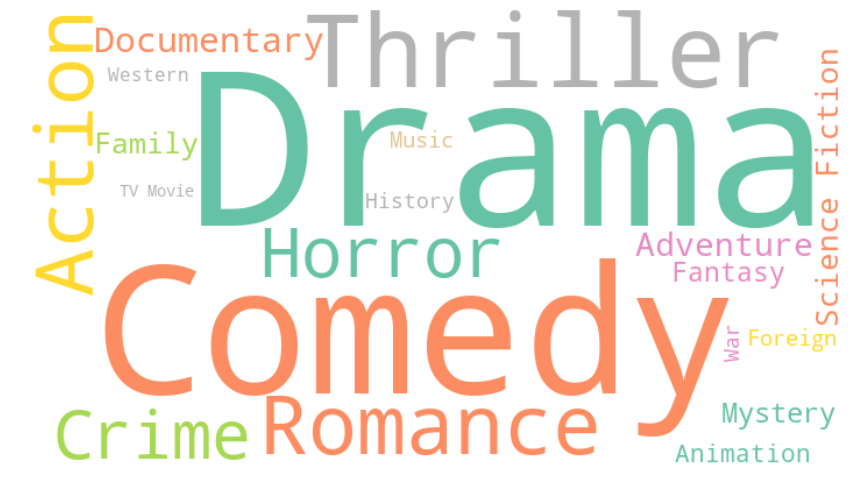

In [32]:
words = dict()
trunc_occurences = genre_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 14 # define the color of the words
f, ax = plt.subplots(figsize=(13, 14))
wordcloud = WordCloud(width=700,height=400, background_color='white', 
                      max_words=1628,relative_scaling=0.5,
                      colormap="Set2_r",
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

___
### 1.5 Actors

We will try to get some insight on the habits of actors. We will focus on a few of data. 

Our first goal is to see the favorite genre of actors. For simplicity, in what follows, we will only consider the actors who appear in first 3 actors in original dataset. In fact, a more exhaustive view would be achieved considering also the two other categories. To proceed with that, I perform some one hot encoding:

At beginning, we should get the actor set to see the hard-working actors.

In [33]:
df_actor = df_initial.copy(deep=True)
set_actor = set(df_actor['actor_name_1']).union(df_actor['actor_name_2']).union(df_actor['actor_name_3'])
set_actor.remove(np.nan)

Calculate the actor_occurences

In [34]:
list_actor = df_actor['actor_name_1'].append(df_actor['actor_name_2']).append(df_actor['actor_name_3'])
list_actor = list_actor.value_counts().reset_index()
actor_occurences = []
for index in list_actor.index:
    actor_occurences.append([list_actor.iloc[index]['index'],list_actor.iloc[index][0]])

Now we could see the wordcloud picture to see the most hard-working actors.

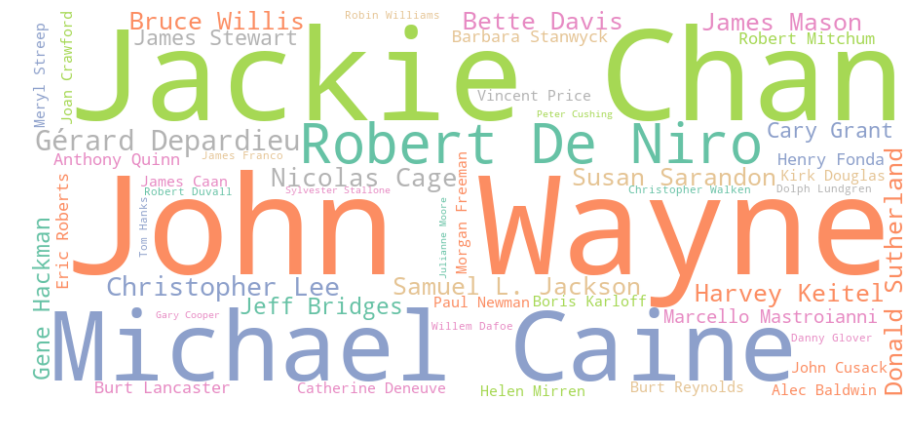

In [35]:
words = dict()
trunc_occurences = actor_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 14 # define the color of the words
f, ax = plt.subplots(figsize=(14, 13))
wordcloud = WordCloud(width=900,height=400, background_color='white', 
                      max_words=1628,relative_scaling=0.5,
                      colormap="Set2_r",
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

___
## 2. Data Exploration


### 2.1 Cleaning  the keywords


In our system, the Keywords play an inportant role in the function of the engine. Our recommendation engine calculates the similarity between movies. For the keywords, we will look for films described by the same keywords. In order to speed up the egine, we have to reserve small enough number of the keywords. 


#### 2.1.1 Grouping by *roots*

NLTK package is an important package to process words, here we group the keywords by their "root" since word's root present most of their information. Then,we caculate the number of occurence of the various keywords for further processing.

Collect the keywords

In [36]:
df_cleaned = df_initial.copy(deep = True)

In [37]:
def keywords_inventory(dataframe, colonne = 'keywords'):
    PS = nltk.stem.PorterStemmer() # implement nltk PorterStemmer
    LB = nltk.stem.WordNetLemmatizer() # implement Lemmatizer
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys = []
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        for t in s.split('|'):
            t = t.lower() ; 
            pre_racine = LB.lemmatize(t) # WordNetLemmatizer can process the plural irregular words 
            racine = PS.stem(pre_racine) # stem PorterStemmer can process a set of words and get it's root
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
            else:
                keywords_roots[racine] = {t}
   # process the sentence keywords : split the setence to several words and select one representative word
    long_similar = dict()
    for s in keywords_roots.keys(): 
        tt = s.split()
        for t in tt:
            count = 0
            for elem in keywords_roots.keys():# make sure this word also appearace in every words in the root's dictionary
                if t == elem and s!=elem:
                    for ss in keywords_roots[s]:
                        if t in ss.split(): 
                            count += 1
                    if count >= len(keywords_roots[elem]): 
                        long_similar[s] = elem
    for s in long_similar.keys():
        for tt in keywords_roots[s]:
            keywords_roots[long_similar[s]].add(tt)
        del keywords_roots[s]
   # select a proper keywords: 
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000 #
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)
            # if the shortest is also a sentence, we have to use the most common words to represent this keywords
            for tt in clef.split():
                count = 0
                for element in keywords_roots[s]:
                    if tt in element :
                        count += 1
                if count >= len(keywords_roots[s]):
                    final_clef = tt
            category_keys.append(final_clef)
            keywords_select[s] = final_clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select

Find the keywords having the same roots and get the shortest word in the same root

In [38]:
keywords, keywords_roots, keywords_select = keywords_inventory(df_cleaned, colonne = 'keywords')

Nb of keywords in variable 'keywords': 7799


Plot 10 keywords that appear in close varieties

In [39]:
# Plot of a sample of keywords that appear in close varieties 
icount = 0
complex_set = dict()
for s in keywords_roots.keys():
    if len(keywords_roots[s]) > 5: 
        icount += 1
        complex_set[s] = keywords_roots[s]
        if icount < 2: 
            print(icount, keywords_roots[s], len(keywords_roots[s]))

1 {'male friendship', 'friendship', 'friendship bracelet', 'interracial friendship', 'unlikely friendship', 'female friendship', 'adult child friendship'} 7


Now, we only know the relations between the similar keywords. Then we plan to replace the original one by the shortest similar one.


##### Replacement of the keywords by the main form using relation keywords_select

In [40]:
def remplacement_df_keywords(df, dico_remplacement, roots):
    df_new = df.copy(deep = True)
    LB = nltk.stem.WordNetLemmatizer()
    for index, row in df_new.iterrows():
        chaine = row['keywords']
        if pd.isnull(chaine): continue
        nouvelle_liste = []
        for s in chaine.split('|'): 
            for key in roots.keys():
                if s in roots[key]:
                    if key in dico_remplacement.keys():
                        nouvelle_liste.append(dico_remplacement[key])
                    else:
                        nouvelle_liste.append(s)       
        df_new.set_value(index, 'keywords', '|'.join(nouvelle_liste)) 
    return df_new

Then we do keywords replacement using the relations we get from above.

In [41]:
df_keywords_cleaned = remplacement_df_keywords(df_cleaned, keywords_select,keywords_roots)
keywords.remove('')

In [42]:
# Plot of a sample of keywords that appear in close varieties 
icount = 0
for s in keywords_roots.keys():
    if len(keywords_roots[s]) > 3: 
        icount += 1
        if icount < 5: print(icount, keywords_roots[s], len(keywords_roots[s])) 

1 {'boy', 'boy scout', 'boy scouts', 'boys'} 4
2 {'male friendship', 'friendship', 'friendship bracelet', 'interracial friendship', 'unlikely friendship', 'female friendship', 'adult child friendship'} 7
3 {'age gap', 'aging', 'age difference', 'old age romance'} 4
4 {'mother daughter relationship', 'father daughter relationship', 'mother daughter estrangement', 'daughter', 'daughter of the president'} 5


In [43]:
# Count of the keywords occurences
keyword_occurences, keywords_count = count_word(df_keywords_cleaned,'keywords',keywords,type_store=1)

In [44]:
print(keyword_occurences[:5])
print('\n'+'The number of keywords-cleaned data has changed to '+str(len(keyword_occurences)))

[['director', 3139], ['film', 2720], ['murder', 1908], ['war', 1275], ['love', 1142]]

The number of keywords-cleaned data has changed to 7590


___
#### 2.1.2 Groups of *synonyms*

In the former data processing section, we have delete the keywords that appearance one time. Then,in this section, we find the keywords that appear less that 5 times and replace them by a synomym of higher frequency.

#### First step: replace low-frequency words by a synomym of higher frequency

In [46]:
# get the synomyms of the word 'word'
def get_synonymes(word):
    lemma = set()
    for ss in wordnet.synsets(word):
        for w in ss.lemma_names():
            
            # We just get the 'nouns':
            index = ss.name().find('.')+1
            if ss.name()[index] == 'n': lemma.add(w.lower().replace('_',' '))
    return lemma   

In [47]:
# Exemple of a list of synonyms given by NLTK
mot_cle = 'alien'
lemma = get_synonymes(mot_cle)
for s in lemma:
    print(' "{:<30}" in keywords list -> {} {}'.format(s, s in keywords,keywords_count[s] if s in keywords else 0 ))

 "foreigner                     " in keywords list -> False 0
 "extraterrestrial              " in keywords list -> True 12
 "stranger                      " in keywords list -> True 31
 "extraterrestrial being        " in keywords list -> False 0
 "alien                         " in keywords list -> True 293
 "outlander                     " in keywords list -> False 0
 "noncitizen                    " in keywords list -> False 0
 "unknown                       " in keywords list -> False 0


In [48]:
# check if 'mot' is a key of 'key_count' with a test on the number of occurences   
def test_keyword(mot, key_count, threshold):
    return (False , True)[key_count.get(mot, 0) >= threshold]

Replace the words with synonymes

In [49]:
keyword_occurences.sort(key = lambda x:x[1], reverse = False)
key_count = dict()
for s in keyword_occurences:
    key_count[s[0]] = s[1]
# Creation of a dictionary to replace keywords by higher frequency keywords
remplacement_mot = dict()
icount = 0
for index, [mot, nb_apparitions] in enumerate(keyword_occurences):
    if nb_apparitions > 5: continue  # only the keywords that appear less than 5 times
    lemma = get_synonymes(mot)
    if len(lemma) == 0: continue     # case of the plurals

    liste_mots = [(s, key_count[s]) for s in lemma 
                  if test_keyword(s, key_count, key_count[mot])]
    liste_mots.sort(key = lambda x:(x[1],x[0]), reverse = True)    
    if len(liste_mots) <= 1: continue       # no replacement
    if mot == liste_mots[0][0]: continue    # replacement by himself
    icount += 1
    if  icount < 8:
        print('{:<12} -> {:<12} (init: {})'.format(mot, liste_mots[0][0], liste_mots))    
    remplacement_mot[mot] = liste_mots[0][0]

print(90*'_'+'\n'+'The replacement concerns {}% of the keywords.'
      .format(round(len(remplacement_mot)/len(keywords)*100,2)))

goose        -> jackass      (init: [('jackass', 2), ('goose', 2)])
evisceration -> disembowelment (init: [('disembowelment', 7), ('evisceration', 2)])
bookstore    -> bookshop     (init: [('bookshop', 10), ('bookstore', 2)])
jurist       -> judge        (init: [('judge', 64), ('justice', 28), ('jurist', 2)])
disk         -> record       (init: [('record', 10), ('disk', 2)])
hugging      -> fondling     (init: [('fondling', 5), ('hugging', 2)])
worrying     -> torment      (init: [('torment', 6), ('worrying', 2)])
__________________________________________________________________________________________
The replacement concerns 4.73% of the keywords.


In [50]:
print('Keywords that appear both in keys and values:'.upper()+'\n'+45*'-')
icount = 0
for s in remplacement_mot.values():
    if s in remplacement_mot.keys():
        icount += 1
        if icount < 10: print('{:<20} -> {:<20}'.format(s, remplacement_mot[s]))

for key, value in remplacement_mot.items():
    if value in remplacement_mot.keys():
        remplacement_mot[key] = remplacement_mot[value]

KEYWORDS THAT APPEAR BOTH IN KEYS AND VALUES:
---------------------------------------------
wind                 -> jazz                
conquest             -> seduction           
guide                -> scout               
rebirth              -> reincarnation       
nirvana              -> heaven              
seal                 -> navy seal           
enchantment          -> spell               
oldtimer             -> veteran             
mistake              -> misunderstanding    


In [51]:
# Replacement of the keywords by the main form(for synonyms)
def remplacement_df_keywords1(df, dico_remplacement, roots):
    df_new = df.copy(deep = True)
    for index, row in df_new.iterrows():
        chaine = row['keywords']
        if pd.isnull(chaine): continue
        nouvelle_liste = []
        for s in chaine.split('|'): 
            clef = PS.stem(LB.lemmatize(s)) if roots else s
            if clef in dico_remplacement.keys():
                nouvelle_liste.append(dico_remplacement[clef])
            else:
                nouvelle_liste.append(s)       
        df_new.set_value(index, 'keywords', '|'.join(nouvelle_liste)) 
    return df_new

In [52]:
# replacement of keyword varieties by the main keyword
df_keywords_synonyms = remplacement_df_keywords1(df_keywords_cleaned, remplacement_mot, roots = False)   
keywords, keywords_roots, keywords_select = keywords_inventory(df_keywords_synonyms, colonne = 'keywords')
keywords.remove('')

Nb of keywords in variable 'keywords': 6649


In [53]:
# New count of keyword occurences
new_keyword_occurences, keywords_count = count_word(df_keywords_synonyms,'keywords',keywords,1)

#### Second step successive replacements
suppress all the keywords that appear in less than 5 films

In [54]:
# deletion of keywords with low frequencies
def remplacement_df_low_frequency_keywords(df, keyword_occurences):
    df_new = df.copy(deep = True)
    key_count = dict()
    for s in keyword_occurences: 
        key_count[s[0]] = s[1]    
    for index, row in df_new.iterrows():
        chaine = row['keywords']
        if pd.isnull(chaine): continue
        nouvelle_liste = []
        for s in chaine.split('|'):       
            if key_count.get(s,4) > 5: nouvelle_liste.append(s)
        df_new.set_value(index, 'keywords', '|'.join(nouvelle_liste))
    return df_new

In [55]:
# Creation of a dataframe where keywords of low frequencies are suppressed
df_keywords_occurence = remplacement_df_low_frequency_keywords(df_keywords_synonyms, new_keyword_occurences)
keywords, keywords_roots, keywords_select = keywords_inventory(df_keywords_occurence, colonne = 'keywords')    
keywords.remove('')

Nb of keywords in variable 'keywords': 3290


In [56]:
# New keywords count
new_keyword_occurences, keywords_count = count_word(df_keywords_occurence,'keywords',keywords,1)
new_keyword_occurences[:5]

[['director', 3139],
 ['film', 2720],
 ['murder', 1908],
 ['war', 1279],
 ['love', 1142]]

plot the Graph of keyword occurences

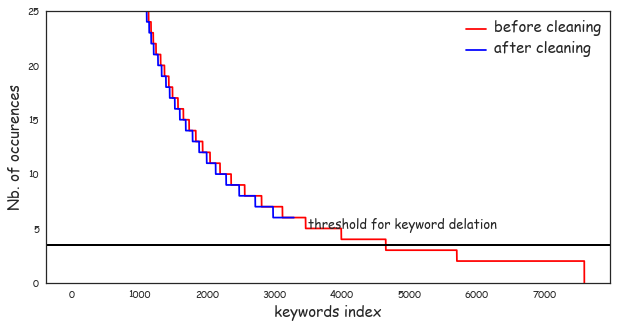

In [57]:
font = {'family' : 'fantasy', 'weight' : 'normal', 'size'   : 15}
mpl.rc('font', **font)

keyword_occurences.sort(key = lambda x:x[1], reverse = True)

y_axis = [i[1] for i in keyword_occurences]
x_axis = [k for k,i in enumerate(keyword_occurences)]

new_y_axis = [i[1] for i in new_keyword_occurences]
new_x_axis = [k for k,i in enumerate(new_keyword_occurences)]

f, ax = plt.subplots(figsize=(9, 5))
ax.plot(x_axis, y_axis, 'r-', label='before cleaning')
ax.plot(new_x_axis, new_y_axis, 'b-', label='after cleaning')

# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('medium')
            
plt.ylim((0,25))
plt.axhline(y=3.5, linewidth=2, color = 'k')
plt.xlabel("keywords index", family='fantasy', fontsize = 15)
plt.ylabel("Nb. of occurences", family='fantasy', fontsize = 15)
#plt.suptitle("Nombre d'occurences des mots clés", fontsize = 18, family='fantasy')
plt.text(3500, 5, 'threshold for keyword delation', fontsize = 13)
plt.show()

The number of keywords decreased almost half of that of original. At the beginning, the number is 11320 which decreased to about 3200.

## 2.1.3 Group by word vectors
Similarity is determined by comparing word vectors or "word embeddings", multi-dimensional meaning representations of a word. SpaCy's similarity model usually assumes a pretty general-purpose definition of similarity. We further shrink the number of keywords.Finally, we can reserve the number of keywords that you want. 

#### Further processing the keywords with the help of spacy methods

Set the nm_keep as the number of keywords you want to reserve.

In [58]:
final_keywords_set  = list()
nm_keep = 1200 # number of keywords that you finally want
for i in range(len(new_keyword_occurences)):
    final_keywords_set.append(new_keyword_occurences[i][0])
set_1 = final_keywords_set[nm_keep:len(new_keyword_occurences)]

In [59]:
documents_left = {}
documents_whole = dict()
for words in final_keywords_set:
    document = nlp(words)
    documents_whole[words] = [document]
for i in range(len(documents_whole)-nm_keep):
    documents_left[set_1[i]]=[]
    for j in range(nm_keep):
        corr_final = 0
        count1 = 0
        for token in documents_whole[set_1[i]]:
            corr = 0
            count = 0
            for token1 in documents_whole[final_keywords_set[j]]:
                corr += token.similarity(token1)
                count+=1
            aaa = corr/count # average similarity
            count1 +=1
            corr_final = corr_final+aaa
        documents_left[set_1[i]].append(corr_final/count1)

In [60]:
replace_dict = dict()
for elem in set_1:
    replace_dict[elem] = final_keywords_set[np.argmax(documents_left[elem])]

In [61]:
# Replacement of the keywords by the main form(for the word vector)
def remplacement_df_keywords_inverse(df, dico_remplacement):
    df_new = df.copy(deep = True)
    for index, row in df_new.iterrows():
        chaine = row['keywords']
        if pd.isnull(chaine): continue
        nouvelle_liste = []
        for s in chaine.split('|'): 
            if s in dico_remplacement.keys():
                nouvelle_liste.append(dico_remplacement[s])
            else:
                nouvelle_liste.append(s)       
        df_new.set_value(index, 'keywords', '|'.join(nouvelle_liste)) 
    return df_new

In [62]:
df_keywords_cleaned_again = remplacement_df_keywords_inverse(df_keywords_occurence, replace_dict)
df_keywords_occurence = df_keywords_cleaned_again
keywords, keywords_roots, keywords_select = keywords_inventory(df_keywords_occurence, colonne = 'keywords')    
keywords.remove('')

Nb of keywords in variable 'keywords': 1201


In [63]:
new_keyword_occurences, keywords_count = count_word(df_keywords_occurence,'keywords',keywords,1)

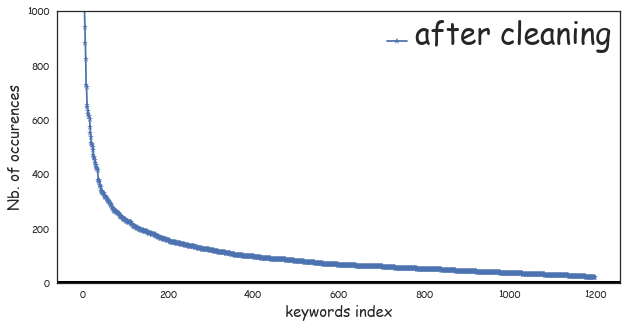

In [64]:
# Graph of keyword occurences
font = {'family' : 'fantasy', 'weight' : 'normal', 'size'   : 30}
mpl.rc('font', **font)

keyword_occurences.sort(key = lambda x:x[1], reverse = True)
new_y_axis = [i[1] for i in new_keyword_occurences]
new_x_axis = [k for k,i in enumerate(new_keyword_occurences)]

f, ax = plt.subplots(figsize=(9, 5))
ax.plot(new_x_axis, new_y_axis, '-*', label='after cleaning')
plt.ylim((0,1000))
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('medium')
plt.axhline(y=3.5, linewidth=2, color = 'k')
plt.xlabel("keywords index", family='fantasy', fontsize = 15)
plt.ylabel("Nb. of occurences", family='fantasy', fontsize = 15)
plt.show()

From the picture, we see that the keywords have only 1200. Also,the density of high-occurance keywords is small.

___
### 2.2 Actor relations

In this section, we just focus on the inner relations between actors. From this part, we could know actors' prefernce of movie genres.

Use a subset of the df_initial to see the inner relations of actors.

In [65]:
df_actor = df_actor.dropna(how='any')
df_actor['popularity'] = df_actor['popularity'].apply(lambda x: float(x))
df_actor['actor_id_1'] = df_actor['actor_id_1'].apply(lambda x: float(x))
df_actor['actor_id_2'] = df_actor['actor_id_2'].apply(lambda x: float(x))
df_actor['actor_id_3'] = df_actor['actor_id_3'].apply(lambda x: float(x))

In [66]:
df_actor_1 = df_actor[['actor_id_1','actor_id_2','actor_id_3','id']].reset_index(drop = True)
for genre in set_genre:
    df_actor_1[genre] = df_initial['genres'].str.contains(genre).apply(lambda x:1 if x else 0)
df_actor_1[0:10]

,actor_id_1,actor_id_2,actor_id_3,id,Thriller,Music,History,Documentary,Fantasy,Science Fiction,Foreign,Horror,Animation,Family,Action,Adventure,Romance,Comedy,War,Drama,Crime,Mystery,Western,TV Movie
0,31.0,12898.0,7167.0,862,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0
1,6837.0,3151.0,13567.0,15602,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
2,8851.0,9780.0,18284.0,31357,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
3,1158.0,380.0,5576.0,949,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0
4,3.0,15887.0,17141.0,11860,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,15111.0,6280.0,8656.0,9091,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0
6,517.0,48.0,10695.0,710,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
7,4173.0,11148.0,6280.0,10858,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0
8,380.0,4430.0,4517.0,524,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
9,204.0,7056.0,3291.0,4584,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0


In [67]:
e=[]
for i in range(3):
    name = 'df_actor_NUM'.replace('NUM', str(i+1))
    actor = 'actor_id_NUM'.replace('NUM', str(i+1))
    actor_1 = 'actor_id_NUM'.replace('NUM', str((i+1)%3+1))
    actor_2 = 'actor_id_NUM'.replace('NUM', str((i+2)%3+1))
    df_actor_2 = df_actor_1.copy(deep=True)
    del df_actor_2[actor_1]
    del df_actor_2[actor_2]
    df_actor_2.rename(columns={actor:'actor_id'},inplace=True)
    e.append(df_actor_2)
df_actor_2 = pd.concat(e)

We get a new dataframe which use the actor as the index. Each actor appears only once while id appears 3 times because one movie keep only 3 actors in our case.

In [68]:
df_actor_2[0:10]

,actor_id,id,Thriller,Music,History,Documentary,Fantasy,Science Fiction,Foreign,Horror,Animation,Family,Action,Adventure,Romance,Comedy,War,Drama,Crime,Mystery,Western,TV Movie
0,31.0,862,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0
1,6837.0,15602,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
2,8851.0,31357,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
3,1158.0,949,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0
4,3.0,11860,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,15111.0,9091,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0
6,517.0,710,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
7,4173.0,10858,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0
8,380.0,524,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
9,204.0,4584,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0


We only keep the actors who acted at more than 8 movies.

In [69]:
temp = df_actor_2['actor_id'].value_counts()
df_actor_3 = df_actor_2.set_index(['actor_id'])
df_actor_3 = df_actor_3.loc[temp > 8].sort_index()
df_actor_3.reset_index(inplace=True)

In [70]:
df_actor_3[0:10]

,actor_id,id,Thriller,Music,History,Documentary,Fantasy,Science Fiction,Foreign,Horror,Animation,Family,Action,Adventure,Romance,Comedy,War,Drama,Crime,Mystery,Western,TV Movie
0,2.0,11,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0
1,2.0,25757,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0
2,2.0,266537,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2.0,372355,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,2.0,31967,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0
5,2.0,1892,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,2.0,331962,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,2.0,42591,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
8,2.0,14711,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0
9,2.0,95511,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0


Now, we could know the actors-genres table.

In [71]:
feature = df_actor_3.groupby('actor_id').sum()
feature.head(5)

,Thriller,Music,History,Documentary,Fantasy,Science Fiction,Foreign,Horror,Animation,Family,Action,Adventure,Romance,Comedy,War,Drama,Crime,Mystery,Western,TV Movie
actor_id,,,,,,,,,,,,,,,,,,,,
2.0,6,0,1,1,0,1,1,0,0,1,6,5,3,5,0,6,4,1,0,0
3.0,4,0,0,1,0,0,0,0,1,2,3,1,1,4,0,12,3,3,0,0
5.0,3,1,0,0,0,2,0,0,1,1,4,1,4,5,3,8,0,1,3,0
31.0,3,2,0,1,4,1,0,1,1,5,2,2,6,10,0,13,2,2,0,0
35.0,5,1,1,2,1,1,1,5,0,2,2,2,2,4,0,6,2,2,0,0


You can see from the table above. Actors always acted in specific genres with high weights while there is 0 weight in other genres.

Calculate the distance of actors based on cosine similarity.

In [72]:
distances = spatial.distance.pdist(feature,'cosine')
distances = spatial.distance.squareform(distances)

In [73]:
kernel_width = distances.mean()
weight = np.exp(-np.power(distances,2)/(kernel_width**2)) - np.eye(distances.shape[0])

keep only 100 strongest distance.

In [74]:
NEIGHBORS = 50
N = len(weight)
# sort the weights from biggest to smallest one.
strongest = np.argsort(-weight)
# only get the first 100 strongest ones.
strongest = strongest[:,0:NEIGHBORS]
choose = np.zeros([N,N])
for i in range(N):
    choose[i,strongest[i,:]]=1

In [75]:
# Be sure that weight matrix stays symmetric.
choose = np.triu(choose)+np.triu(choose).T
weights = choose * weight
np.nonzero(weights-weights.transpose())

(array([], dtype=int64), array([], dtype=int64))

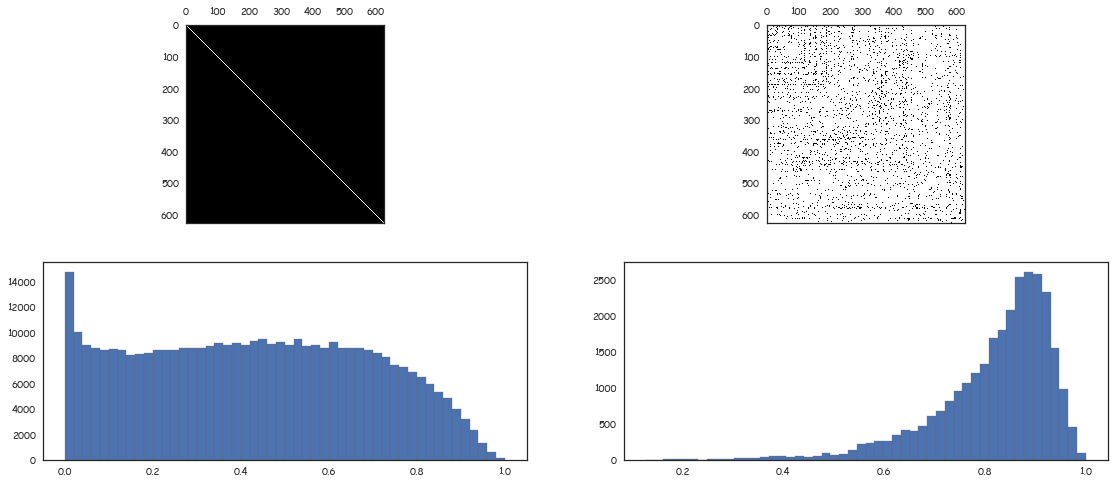

In [76]:
fix, axes = plt.subplots(2, 2, figsize=(17, 8))
def plot(weights, axes):
    axes[0].spy(weights) # The first plot of weights matrix
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50); # the degrees distrubutions
    
plot(weight, axes[:, 0]) # left side plot
plot(weights, axes[:, 1]) # right side graph

___
### 2.4 Correlations
From the relations of actor and movies, we could know that actors and movies are likely to cluster by genres. We then plot a correlation map.
The correlations can help us to have a clear notice of most relevant features, which will help us to determine 
the features that we will use in the Engine.

In [77]:
df_keywords_occurence_de = df_keywords_occurence.copy(deep =True)
df_keywords_occurence_de[df_keywords_occurence_de['budget']== 0]['budget']=np.nan
df_keywords_occurence_de[df_keywords_occurence_de['revenue']== 0]['revenue']=np.nan
df_keywords_occurence_de[df_keywords_occurence_de['runtime']== 0]['time']=np.nan
df_keywords_occurence_de[df_keywords_occurence_de['vote_count']== 0]['time']=np.nan
df_keywords_occurence_de = df_keywords_occurence_de.dropna(how='any')
df_keywords_occurence_de['popularity'] = df_keywords_occurence_de['popularity'].apply(lambda x: float(x))

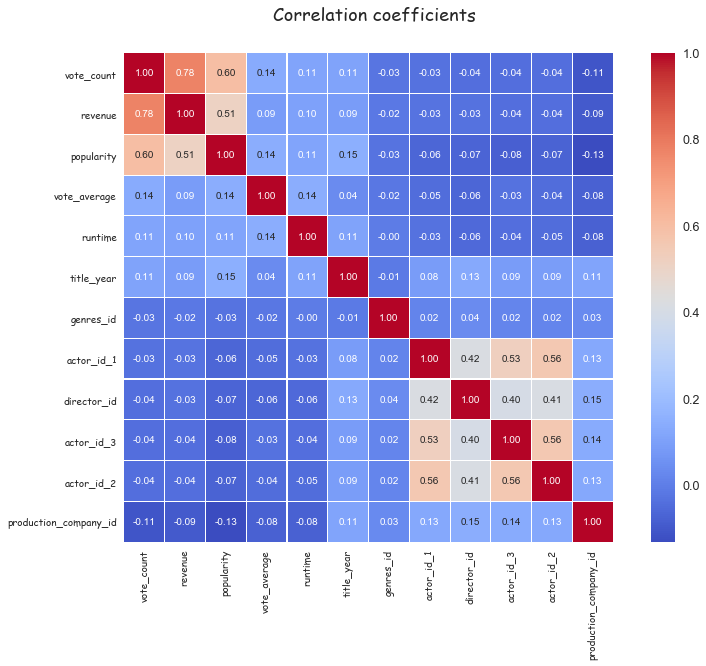

In [78]:
f, ax = plt.subplots(figsize=(12, 9))
#_____________________________
# calculations of correlations
corrmat = df_keywords_occurence_de.corr()
#________________________________________
k = 17 # number of variables for heatmap
cols = corrmat.nlargest(k, 'vote_count')['vote_count'].index
cm = np.corrcoef(df_keywords_occurence_de[cols].dropna(how='any').values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'coolwarm',
                 yticklabels=cols.values, xticklabels=cols.values)
f.text(0.5, 0.93, "Correlation coefficients", ha='center', fontsize = 18, family='fantasy')
plt.show()

According to the values reported above, I delete a few variables from the dataframe and then re-order the columns.

In [79]:
df_var_cleaned = df_keywords_occurence.copy(deep = True)

___
###  2.4 Missing values
I examine the number of missing values in each variable and then choose a methodology to complete the dataset.

In [80]:
missing_df = df_var_cleaned.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df_var_cleaned.shape[0] 
                                - missing_df['missing_count']) / df_var_cleaned.shape[0] * 100
missing_df = missing_df.sort_values('filling_factor').reset_index(drop = True)
missing_df

,column_name,missing_count,filling_factor
0,director,19941,56.140853
1,director_id,19941,56.140853
2,production_company_id,11881,73.868385
3,actor_id_3,4659,89.752782
4,actor_name_3,4659,89.752782
5,actor_id_2,3749,91.754278
6,actor_name_2,3749,91.754278
7,genres_id,2442,94.628954
8,actor_id_1,2417,94.683940
9,actor_name_1,2417,94.683940


The content of this table is now represented:

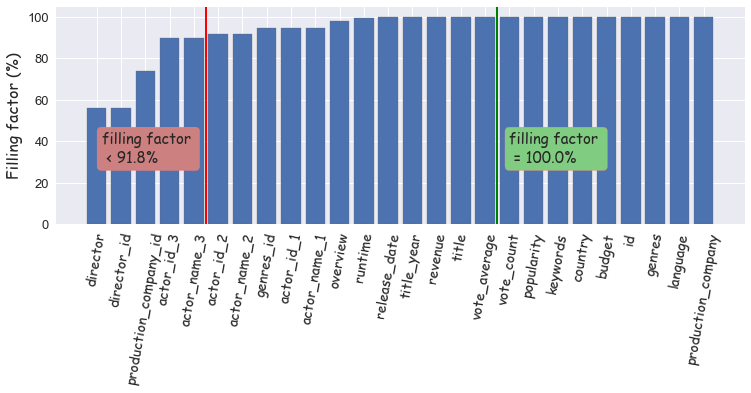

In [81]:
y_axis = missing_df['filling_factor'] 
x_label = missing_df['column_name']
x_axis = missing_df.index

fig = plt.figure(figsize=(11, 4))
plt.xticks(rotation=80, fontsize = 14)
plt.yticks(fontsize = 13)

N_thresh = 5
plt.axvline(x=N_thresh-0.5, linewidth=2, color = 'r')
plt.text(N_thresh-4.8, 30, 'filling factor \n < {}%'.format(round(y_axis[N_thresh],1)),
         fontsize = 15, family = 'fantasy', bbox=dict(boxstyle="round",
                   ec=(1.0, 0.5, 0.5),
                   fc=(0.8, 0.5, 0.5)))
N_thresh = 17
plt.axvline(x=N_thresh-0.5, linewidth=2, color = 'g')
plt.text(N_thresh, 30, 'filling factor \n = {}%'.format(round(y_axis[N_thresh],1)),
         fontsize = 15, family = 'fantasy', bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(0.5, 0.8, 0.5)))

plt.xticks(x_axis, x_label,family='fantasy', fontsize = 14 )
plt.ylabel('Filling factor (%)', family='fantasy', fontsize = 16)
plt.bar(x_axis, y_axis);

___
#### 2.4.1 Setting missing title years

 To infer the title year, For actors and the director, we determine the mean year of activity, using the current dataset. we then average the values obtained to estimate the title year.

In [82]:
df_filling = df_var_cleaned.copy(deep=True)
missing_year_info = df_filling[df_filling['title_year'].isnull()][['director_id','actor_id_1','actor_id_1', 'actor_id_3']]

In [83]:
def fill_year(df):
    col = ['director_id', 'actor_id_1', 'actor_id_2', 'actor_id_3']
    usual_year = [0 for _ in range(4)]
    var        = [0 for _ in range(4)]

    # I get the mean years of activity for the actors and director
    for i in range(4):
        usual_year[i] = df.groupby(col[i])['title_year'].mean()

    # I create a dictionnary collectinf this info
    actor_year = dict()
    for i in range(4):
        for s in usual_year[i].index:
            if s in actor_year.keys():
                if pd.notnull(usual_year[i][s]) and pd.notnull(actor_year[s]):
                    actor_year[s] = (actor_year[s] + usual_year[i][s])/2
                elif pd.isnull(actor_year[s]):
                    actor_year[s] = usual_year[i][s]
            else:
                actor_year[s] = usual_year[i][s]
        
    # identification of missing title years
    missing_year_info = df[df['title_year'].isnull()]

    # filling of missing values
    icount_replaced = 0
    for index, row in missing_year_info.iterrows():
        value = [ np.NaN for _ in range(4)]
        icount = 0 ; sum_year = 0
        for i in range(4):            
            var[i] = df.loc[index][col[i]]
            if pd.notnull(var[i]): value[i] = actor_year[var[i]]
            if pd.notnull(value[i]): icount += 1 ; sum_year += actor_year[var[i]]
        if icount != 0: sum_year = sum_year / icount 

        if int(sum_year) > 0:
            icount_replaced += 1
            df.set_value(index, 'title_year', int(sum_year))
            if icount_replaced < 10: 
                print("{:<45} -> {:<20}".format(df.loc[index]['title'],int(sum_year)))
    return 

In [84]:
fill_year(df_filling)

Vermont Is for Lovers                         -> 2015                
Bling: A Planet Rock                          -> 1983                
Human Failure                                 -> 2000                
nan                                           -> 1992                
nan                                           -> 1996                
The Awful Truth                               -> 1994                
Electile Dysfunction: Inside the Business of American Campaigns -> 2001                
Aurinkotuuli                                  -> 1998                
Enola Gay and the Atomic Bombing of Japan     -> 2005                


___
#### 2.4.2  Keywords from the title

keywords usually play an important role in the functioning of the engine. Hence,filling missing values in the **plot_keywords** variable using the words of the title.Firstly,we create the list of synonyms of all the words contained in the title and I check if any of these synonyms are already in the keyword list. When it is the case, I add this keyword to the entry:

In [85]:
icount = 0
for index, row in df_filling[df_filling['keywords'].isnull()].iterrows():
    icount += 1
    liste_mot = row['title'].strip().split()
    new_keyword = []
    for s in liste_mot:
        lemma = get_synonymes(s)
        for t in list(lemma):
            if t in keywords: 
                new_keyword.append(t)                
    if new_keyword and icount < 15: 
        print('{:<50} -> {:<30}'.format(row['title'], str(new_keyword)))
    if new_keyword:
        df_filling.set_value(index, 'keywords', '|'.join(new_keyword)) 

#### 2.4.3 Imputing from regressions

In Section 2.4, we had a look at the correlation between variables and found that a few of them showed some degree of correlation, with a Pearson's coefficient > 0.5:

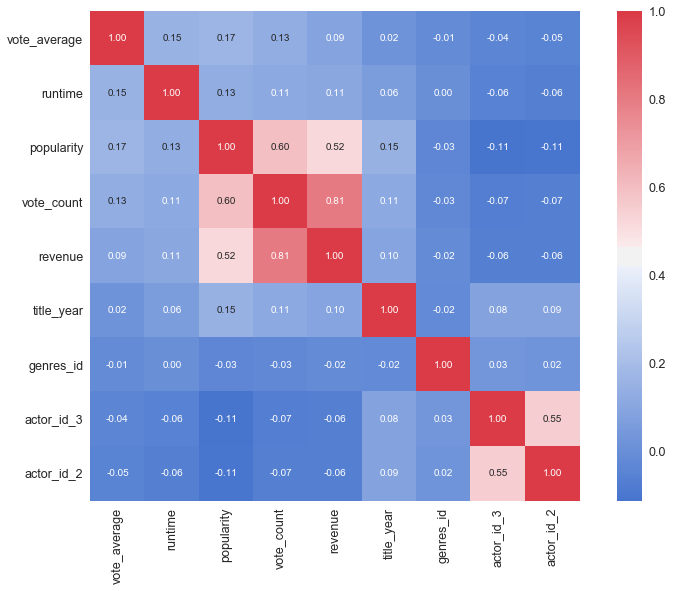

In [86]:
f, ax = plt.subplots(figsize=(12, 9))
cols = corrmat.nlargest(9, 'vote_average')['vote_count'].index
temp = df_keywords_occurence[cols].dropna(how='any')
temp['popularity'] = temp['popularity'].apply(lambda x: float(x))
# temp.dtype = 'float'
cm = np.corrcoef(temp.values.T)
sns.set(font_scale=1.25)
cmap = sns.diverging_palette(256, 10, as_cmap=True)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,cmap =cmap,
                 fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

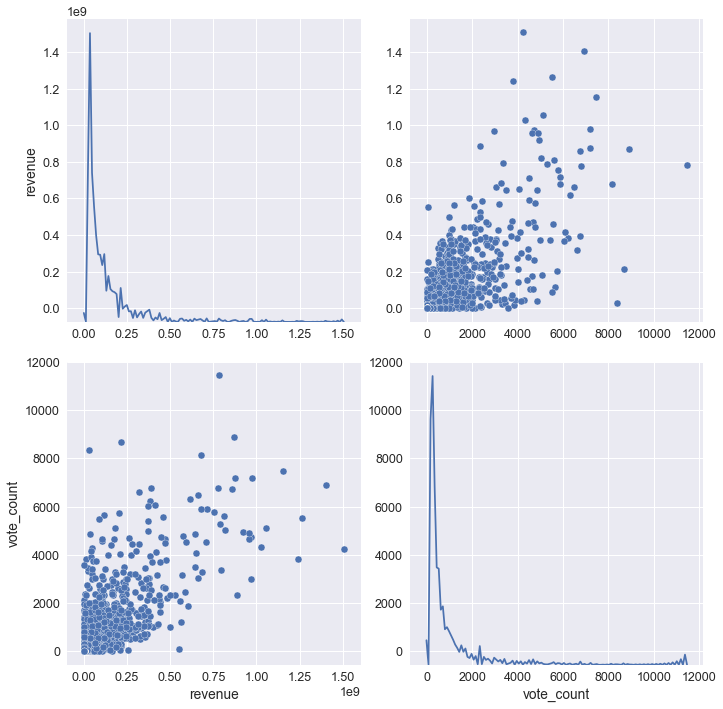

In [87]:
sns.set(font_scale=1.25)
cols = ['revenue', 'vote_count']
sns.pairplot(df_filling.dropna(how='any')[cols],diag_kind='kde', size = 5)
plt.show();

First, we define a function that impute the missing value from a linear fit of the data:

In [88]:
def variable_linreg_imputation(df, col_to_predict, ref_col):
    regr = linear_model.LinearRegression()
    test = df[[col_to_predict,ref_col]].dropna(how='any', axis = 0)
    X = np.array(test[ref_col])
    Y = np.array(test[col_to_predict])
    X = X.reshape(len(X),1)
    Y = Y.reshape(len(Y),1)
    regr.fit(X, Y)
    
    test = df[df[col_to_predict].isnull() & df[ref_col].notnull()]
    for index, row in test.iterrows():
        value = float(regr.predict(row[ref_col]))
        df.set_value(index, col_to_predict, value)

This function takes the dataframe as input, as well as the names of two columns. A linear fit is performed between those two columns which is used to fill the holes in the first column that was given:

In [89]:
variable_linreg_imputation(df_filling, 'revenue', 'vote_count')

Finally, I examine which amount of data is still missing in the dataframe:

In [90]:
df = df_filling.copy(deep = True)
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df.shape[0] 
                                - missing_df['missing_count']) / df.shape[0] * 100
missing_df = missing_df.sort_values('filling_factor').reset_index(drop = True)
missing_df

,column_name,missing_count,filling_factor
0,director,19941,56.140853
1,director_id,19941,56.140853
2,production_company_id,11881,73.868385
3,actor_id_3,4659,89.752782
4,actor_name_3,4659,89.752782
5,actor_id_2,3749,91.754278
6,actor_name_2,3749,91.754278
7,genres_id,2442,94.628954
8,actor_id_1,2417,94.683940
9,actor_name_1,2417,94.683940


and we can see that in the worst case, the filling factor is around 96% (excluding the **homepage** and **tagline** variables).

In [91]:
df = df_filling.copy(deep=True)
df.reset_index(inplace = True, drop = True)

In [92]:
df[:5]

,budget,genres,id,overview,popularity,release_date,revenue,runtime,title,vote_average,vote_count,title_year,production_company_id,director_id,director,actor_id_1,actor_name_1,actor_id_2,actor_name_2,actor_id_3,actor_name_3,keywords,genres_id,country,language,production_company
0,30000000,Animation|Comedy|Family,862,"Led by Woody, Andy's toys live happily in his ...",21.9469,1995-10-30,373554033.0,81.0,Toy Story,7.7,5415.0,1995.0,3.0,7879.0,John Lasseter,31.0,Tom Hanks,12898.0,Tim Allen,7167.0,Don Rickles,jealousy|toy|boy|friendship|friend|rivalry|door,16.0,United States of America,English,Pixar Animation Studios
1,65000000,Adventure|Fantasy|Family,8844,When siblings Judy and Peter discover an encha...,17.0155,1995-12-15,262797249.0,104.0,Jumanji,6.9,2413.0,1995.0,559.0,NaN,NaN,2157.0,Robin Williams,8537.0,Jonathan Hyde,205.0,Kirsten Dunst,road movie|disappearance|book|new zealand|rain...,12.0,United States of America,English|Français,TriStar Pictures|Teitler Film|Interscope Commu...
2,0,Romance|Comedy,15602,A family wedding reignites the ancient feud be...,11.7129,1995-12-22,0.0,101.0,Grumpier Old Men,6.5,92.0,1995.0,6194.0,26502.0,Howard Deutch,6837.0,Walter Matthau,3151.0,Jack Lemmon,13567.0,Ann-Margret,fish|friend|duringcreditsstinger|men,10749.0,United States of America,English,Warner Bros.|Lancaster Gate
3,16000000,Comedy|Drama|Romance,31357,"Cheated on, mistreated and stepped on, the wom...",3.85949,1995-12-22,81452156.0,127.0,Waiting to Exhale,6.1,34.0,1995.0,306.0,2178.0,Forest Whitaker,8851.0,Whitney Houston,9780.0,Angela Bassett,18284.0,Loretta Devine,based on novel|single mother|divorce,35.0,United States of America,English,Twentieth Century Fox Film Corporation
4,0,Comedy,11862,Just when George Banks has recovered from his ...,8.38752,1995-02-10,76578911.0,106.0,Father of the Bride Part II,5.7,173.0,1995.0,5842.0,NaN,NaN,67773.0,Steve Martin,3092.0,Diane Keaton,519.0,Martin Short,baby|midlife crisis|reunion|divorce|daughter|d...,35.0,United States of America,English,Sandollar Productions|Touchstone Pictures


In [93]:
df.to_csv('df.csv',index=False)

### 2.5 Movie Clustering


Cluster the movies into two groups with the help of eigenvectors

In [94]:
gaussian_filter = lambda x,y,sigma: math.exp(-(x-y)**2/(2*sigma**2))

In [95]:
def entry_variables(df, id_entry): 
    col_labels = []    
    if pd.notnull(df['director'].iloc[id_entry]):
        for s in df['director'].iloc[id_entry].split('|'):
            col_labels.append(s)
            
    for i in range(3):
        column = 'actor_name_NUM'.replace('NUM', str(i+1))
        if pd.notnull(df[column].iloc[id_entry]):
            for s in df[column].iloc[id_entry].split('|'):
                col_labels.append(s)
                
    if pd.notnull(df['keywords'].iloc[id_entry]):
        for s in df['keywords'].iloc[id_entry].split('|'):
            col_labels.append(s)
    return col_labels

In [96]:
def add_variables(df, REF_VAR):    
    for s in REF_VAR: df[s] = pd.Series([0 for _ in range(len(df))])
    colonnes = ['genres', 'actor_name_1', 'actor_name_2',
                'actor_name_3', 'director', 'keywords']
    for categorie in colonnes:
        for index, row in df.iterrows():
            if pd.isnull(row[categorie]): continue
            for s in str(row[categorie]).split('|'):
                if s in REF_VAR:
                    if categorie == 'genres': df.set_value(index, s, 1.3) 
                    else: df.set_value(index, s, 1)            
    return df

Sample the movie by delete the moives that have NAN data

In [97]:
df = df_filling.copy(deep=True)
df.reset_index(inplace = True, drop = True)

In [98]:
df_cluster= df_keywords_occurence.copy(deep=True)
df_cluster = df_cluster.dropna(how = 'any').reset_index()

Sample the dataset.

In [99]:
df_cluster = df_cluster[:255] 

In [100]:
s = (len(df_cluster),len(df_cluster))
cluster_weights = np.zeros(s)

In [102]:
for i in range(len(df_cluster)):
    id_entry = i
    df_copy = df_cluster.copy(deep = True)    
    liste_genres = set()
    for s in df['genres'].str.split('|').values:
        liste_genres = liste_genres.union(set(s))    

    # Create additional variables to check the similarity
    variables = entry_variables(df_copy, id_entry)
    variables += list(liste_genres)
    df_new = add_variables(df_copy, variables)

    # determination of the closest neighbors: the distance is calculated / new variables
    X = df_new.as_matrix(variables)
    nbrs = NearestNeighbors(n_neighbors=31, algorithm='auto', metric='euclidean').fit(X)

    distances, indices = nbrs.kneighbors(X)    
    xtest = df_new.iloc[id_entry].as_matrix(variables)
    xtest = xtest.reshape(1, -1)

    distances, indices = nbrs.kneighbors(xtest)
    for j in range(len(indices[0])):       
        a = distances[0]
        b = indices[0]
        cluster_weights[i][b[j]] = a[j]
        cluster_weights[b[j]][i] = a[j]

In [104]:
s=set()
for i in df['genres'].str.split('|').values:
    s=s.union(set(i))

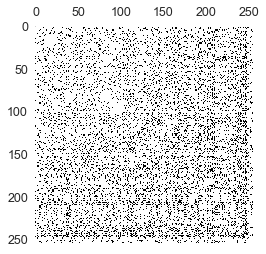

In [105]:
weights = cluster_weights.copy()
plt.spy(weights)

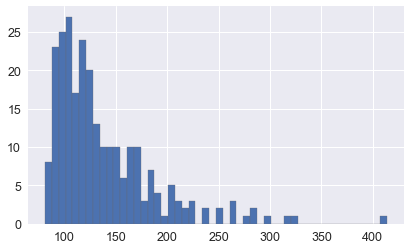

In [106]:
degrees =[sum(weights[i,:]) for i in range(len(weights))]
plt.hist(degrees, bins=50);

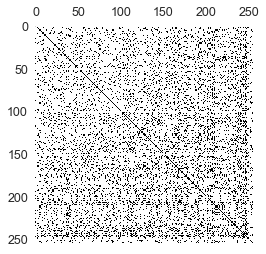

In [107]:
laplacian =  sparse.csgraph.laplacian(weights, normed=True)
plt.spy(laplacian);

In [108]:
laplacian = sparse.csr_matrix(laplacian)
laplacian.count_nonzero()
remaining_edges = laplacian.count_nonzero()/2
print("the remaining edges number is {}".format(int(remaining_edges)))

the remaining edges number is 5572


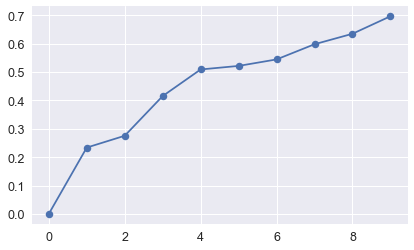

In [109]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian,k = 10,which='SM')
plt.plot(eigenvalues, '.-', markersize=15);

In [110]:
x =eigenvectors[:, 1]
y =eigenvectors[:, 2]

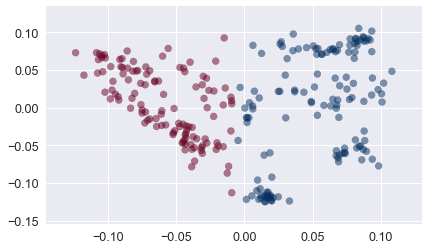

In [111]:
labels =  eigenvectors[:, 1]> eigenvectors.mean() 
plt.scatter(x, y, c=labels, cmap='RdBu', alpha=0.5);

In [112]:
a = []
for i in range(len(labels)):
    if labels[i] == True:
        a.append(i)
b = []
for i in range(len(labels)):
    if labels[i] == False:
        b.append(i)

In [113]:
df_group1 = df_cluster.copy()
df_group1 = df_group1.drop(a)
df_group2 = df_cluster.copy()
df_group2 = df_group2.drop(b)


In [114]:
set_keywords = set()
for list_keywords in df_group1['genres'].str.split('|').values:
    if isinstance(list_keywords, float): continue  # only happen if liste_keywords = NaN
    set_keywords = set_keywords.union(list_keywords)
# remove null chain entry
set_keywords2 = set()
for list_keywords in df_group2['genres'].str.split('|').values:
    if isinstance(list_keywords, float): continue  # only happen if liste_keywords = NaN
    set_keywords2 = set_keywords2.union(list_keywords)

In [115]:
Group1 =count_word(df_group2,'genres',set_keywords2,1)
Group2 = count_word(df_group1,'genres',set_keywords,1)

In [116]:
Group1_list = Group1[0]
Group1_list[:3]

[['Comedy', 97], ['Drama', 74], ['Romance', 63]]

In [117]:
Group2_list = Group2[0]
Group2_list[:3]

[['Drama', 74], ['Thriller', 59], ['Action', 44]]

From the results above we can see that the genres of group1 are similar and that of group2 are similar.

___
## 3. RECOMMENDATION ENGINE BASED ON MOVIE

___
### 3.1 Basic functioning of the engine 
 In order to build the recommendation engine,  basically proceed in two steps:
1. determine $N$ films with a content similar to the entry provided by the user
2. select the 5 most popular films among these $N$ films ( we select $N$=31 as the test)

#### 3.1.1 Similarity
The first step is to define a criteria that would tell us how close two films are. we extract features of the director name, the names of the actors ,a few keywords and genres,then build a matrix like below



|  movie title |director   |actor 1   |actor 2   |actor 3   | keyword 1  | keyword 2   | genre 1 | genre 2 | ... | genre k |
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|Film 1   | $a_{11}$  |  $a_{12}$ |   |   |  ... |   |   |   |   | $a_{1q}$  |
|...   |   |   |   |   | ...  |   |   |   |   |   |
|Film i   |  $a_{i1}$ | $a_{i2}$ |   |   | $a_{ij}$  |   |   |   |   |  $a_{iq}$ |
|...   |   |   |   |   | ...  |   |   |   |   |   |
| Film p   |$a_{p1}$   | $a_{p2}$  |   |   | ...  |   |   |   |   | $a_{pq}$  |

We compare these features of each movie with the features of the given movie.Then we put the outcome into the matrix(the matrix entries can be 0, 1 or other numbers >0).

If a movie has a different fearue to the one of the selected movie, we set it to 0;
 
else, if they share a same feature, we set it to a positive number, usually 1. Concerning the weight of this feature, it can also be other positive numbers. For example, we give the "genre" feature a weight of 1.7.

For exemple, if "keyword 1" is in film $i$, we will have $a_{ij}$ = 1 and 0 otherwise. Since we think genres fearture is more important, we set $a_{ij}$ = p or 0 ( p=1.7 here)

Once this matrix has been defined, we determine the distance between two films according to:

\begin{eqnarray}
d_{m, n} = \sqrt{  \sum_{i = 1}^{N} \left( a_{m,i}  - a_{n,i} \right)^2  } 
\end{eqnarray}

At this stage, we just have to select the N films which are the closest from the entry selected by the user.

#### 3.1.2 Popularity

According to similarities between entries, we get a list of $N$ films. At this stage, we select 5 films from this list and give a score for every entry. We decide de compute the score according to 3 criteria:
- the IMDB score
- the number of votes the entry received
- the year of release

Then, we calculate the score according to the formula:


\begin{eqnarray}
\mathrm{score} = IMDB^2 \times \phi_{\sigma_1, c_1} \times  \phi_{\sigma_2, c_2}
\end{eqnarray}

where $\phi$ is a gaussian function:

\begin{eqnarray}
\phi_{\sigma, c}(x) \propto \mathrm{exp}\left(-\frac{(x-c)^2}{2 \, \sigma^2}\right)
\end{eqnarray}

For votes, we get the maximum number of votes among the $N$ films and set $\sigma_1 = c_1 $= max_user. 

For years, we put $\sigma_1 = 20$ and center the gaussian on the title year of the film selected by the user. With the gaussians, we put more weight to the entries with a large number of votes and to the films whose release year is close to the title selected by the user.

___
### 3.2 Definition of the engine functions

In [118]:
def gaussian_filter(x,y,sigma):
    value = math.exp(-(x-y)**2/(2*sigma**2))
    return value

 **Function initial_variables**: this function returns the values taken by the variables *'director\_name', 'plot\_keywords''*  and *'actor\_N\_name'*(N $\in$ [1:3]) for the film selected by the user.

In [119]:
def initial_variables(df_tem, id_entry):    
    labels = []       
    if pd.notnull(df_tem['director'].iloc[id_entry]):
        for v in df_tem['director'].iloc[id_entry].split('|'):
            labels.append(v)
    
    if pd.notnull(df_tem['keywords'].iloc[id_entry]):
        for v in df_tem['keywords'].iloc[id_entry].split('|'):
            labels.append(v)
            
    for i in range(3):
        column = 'actor_name_NUM'.replace('NUM', str(i+1))
        if pd.notnull(df_tem[column].iloc[id_entry]):
            for v in df_tem[column].iloc[id_entry].split('|'):
                labels.append(v)
                
    return labels

 **Function create_matrix**: this function add a list of variables to the dataframe given in input and initialize these variables at 0,1,or 1.7 depending on the correspondance with the description of the films and the content of the intial_var variable given in input.

In [120]:
def create_matrix(df_tem, intial_var): 
        
    columns = ['genres', 'actor_name_1', 'actor_name_2',
                'actor_name_3', 'director', 'keywords']
    
    for s in intial_var: 
        df_tem[s] = pd.Series([0 for _ in range(len(df_tem))])
        
    for categorie in columns:
        for index, row in df_tem.iterrows():
            if pd.isnull(row[categorie]): continue
            for s in row[categorie].split('|'):
                if s in intial_var:
                    #setting genres weight is 1.7
                    if categorie == 'genres': df_tem.set_value(index, s, 1.7) 
                    else: df_tem.set_value(index, s, 1)            
    return df_tem

 **Function similarity**: this function create a list of N (= 31) films similar to the film selected by the user according to the length of their eculidean disatnces.

In [121]:
def similarity(df_tem,id_entry):       
    list_genres = set()
    for s in df_tem['genres'].str.split('|').values:
        list_genres = list_genres.union(set(s))   
        
    # Create additional variables to check the similarity
    variables = initial_variables(df_tem, id_entry)
    variables += list(list_genres)
    df_distance = create_matrix(df_tem, variables)
    
    # use NearestNeighbors to calculate the euclidean distance
    dist_matrix = df_distance.as_matrix(variables)
    
    nbrs = NearestNeighbors(n_neighbors=31, algorithm='auto', metric='euclidean').fit(dist_matrix)

    distances, indices = nbrs.kneighbors(dist_matrix)    
    
    dist_matrix_test = df_distance.iloc[id_entry].as_matrix(variables).reshape(1,-1)

    distances, indices = nbrs.kneighbors(dist_matrix_test)

    return indices[0][:]
    

 **Function popularity_score**: this function gives a score to a film depending on its IMDB score, title, year and the number of users who have voted for this film.

In [122]:
def popularity_score(title_main, max_users, year_ref, title, year, imdb_score, votes):    
    if pd.notnull(year_ref):
        factor_year = gaussian_filter(year_ref, year, 20)
    else: 
        factor_year = 1        

    sigma = max_users * 1.0

    if pd.notnull(votes):
        factor_vote = gaussian_filter(votes, max_users, sigma)
    else: 
        factor_vote = 0
        
    if title_similartiy(title_main, title):
        note = 0
    else:
        note = imdb_score**2 * factor_year * factor_vote
    
    return note

 **Function extract_parameters**: this function extracts some variables of the dataframe given in input and returns this list for a selection of N films. This list is ordered according to criteria established in the *popularity_score* function.

In [123]:
def extract_parameters(df_tem, list_films):     
    
    parametres_films = ['_' for _ in range(31)]
    
    i =0
    max_users = -1
    
    for index in list_films:
        parametres_films[i] = list(df_tem.iloc[index][['title', 'title_year',
                                        'vote_average', 'overview', 
                                        'vote_count','language','genres']])
        #add index
        parametres_films[i].append(index)
        #get the maximum vote_count
        max_users = max(max_users, parametres_films[i][4] )
        i += 1
        

    title_main = parametres_films[0][0]
    year_ref  = parametres_films[0][1]
    
    #sorted the parametres_films according to their popularity score
    parametres_films.sort(key = lambda x:popularity_score(title_main, max_users,
                                   year_ref, x[0], x[1], x[2], x[4]), reverse = True)
    
    return parametres_films 

 **Function title_similartiy**: this function compares the 2 titles passed in input and defines if these titles are similar or not.

In [124]:
def title_similartiy(title_1, title_2): 
   
    if fuzz.ratio(title_1, title_2) > 50 or fuzz.token_set_ratio(title_1, title_2) > 50:
    
        return True
    else:
        return False
        

 **Function popularity_selection**: this function complete the *film\_selection* list which contains 5 films that will be recommended to the user. The films are selected from the *parametres\_films* list and are taken into account only if the title is different enough from other film titles. 

In [125]:
def popularity_selection(film_selection, parametres_films):    
    film_list = film_selection[:]
    film_num = len(film_list)
    
    for i in range(31):
        already_in_list = False
        for s in film_selection:
            if s[0] == parametres_films[i][0]: 
                already_in_list = True
            if title_similartiy(parametres_films[i][0], s[0]): 
                already_in_list = True            
        if already_in_list: 
            continue
            
        film_num += 1
        
        if film_num <= 5:
            film_list.append(parametres_films[i])
            
    return film_list

 **Function remove_latest_sametitle**: this function remove sequels from the list if more that two films from a serie are present. The older one is kept.

In [126]:
def reserve_latest_sametitle(film_selection):    
    removed_from_selection = []
    for i, film_1 in enumerate(film_selection):
        for j, film_2 in enumerate(film_selection):
            if j <= i: continue 
            if title_similartiy(film_1[0], film_2[0]): 
                last_film = film_2[0] if film_1[1] < film_2[1] else film_1[0]
                removed_from_selection.append(last_film)
    film_list = [film for film in film_selection if film[0] not in removed_from_selection]

    return film_list

**Main function**: create a list of 5 films that will be recommended to the user.

In [127]:
def movie_recommendation(df_tem, id_entry, del_new, verbose):    
    if verbose: 
        print(100*'_' + '\n' + "Recommendation: Films similar to id={} -> title: '{}'  genres:'{}'.".format(id_entry,
                                df_tem.iloc[id_entry]['title'],df_tem.iloc[id_entry]['genres']))
        print('This film is about: {}'.format(df_tem.iloc[id_entry]['overview']))
        
    # Create a list of 31 films according the distance
    list_films = similarity(df_tem, id_entry)
    
    # Sort a list of 31 films according the popularyity score 
    parametres_films = extract_parameters(df_tem, list_films)
    
    # Select 5 films from this list 
    film_selection = []
    film_selection = popularity_selection(film_selection, parametres_films)
    
    # Delete the old movies that have same title
    if del_new: film_selection = reserve_latest_sametitle(film_selection)
        
    # Add new films to complete the list
    film_selection = popularity_selection(film_selection, parametres_films)
    
    selection_titles = []
    
    #Print the recommendation
    for i,s in enumerate(film_selection):
        selection_titles.append([s[0].replace(u'\xa0', u''), s[3],s[6]])
        if verbose: 
            print("nº{:<2}     -> {:<30}".format(i+1, s[0]))
           

    return selection_titles

___
### 3.3 Making meaningful recommendations

Firtly, we face a small issue: the existence of same title makes that some recommendations may seem quite unreasonable.For exemple, somebody who liked *"'The NeverEnding Story'* would be recommend by these movie that he may not like:

In [128]:
dum = movie_recommendation(df, 2052, False,  True)

____________________________________________________________________________________________________
Recommendation: Films similar to id=2052 -> title: 'The NeverEnding Story'  genres:'Drama|Family|Fantasy|Adventure'.
This film is about: While hiding from bullies in his school's attic, a young boy discovers the extraordinary land of Fantasia, through a magical book called The Neverending Story. The book tells the tale of Atreyu, a young warrior who, with the help of a luck dragon named Falkor, must save Fantasia from the destruction of The Nothing.
nº1      -> Harry Potter and the Philosopher's Stone
nº2      -> Harry Potter and the Chamber of Secrets
nº3      -> Harry Potter and the Prisoner of Azkaban
nº4      -> Jumanji                       
nº5      -> Harry Potter and the Goblet of Fire


This issue is quite easily understood: these movies series share the same director, actors and keywords,so it is quite probable that this engine will recommend a series of films. In the previous exemple, we see that the engine recommends the three films of the *"Harry Potter and the Philosopher's Stone"* trilogy, as well as *"Harry Potter and the Chamber of Secrets"* and *"Harry Potter and the Prisoner of Azkaban"*.

Hence, we used the **fuzzywuzzy** package to build the *reserve_latest_sametitle* function. This function defines the degree of similarity of two film titles and if too close, the most recent film is removed from the list of recommendations.

In [129]:
df2=df.copy(deep=True)
dum2 = movie_recommendation(df2, 2052,  True,  True)

____________________________________________________________________________________________________
Recommendation: Films similar to id=2052 -> title: 'The NeverEnding Story'  genres:'Drama|Family|Fantasy|Adventure'.
This film is about: While hiding from bullies in his school's attic, a young boy discovers the extraordinary land of Fantasia, through a magical book called The Neverending Story. The book tells the tale of Atreyu, a young warrior who, with the help of a luck dragon named Falkor, must save Fantasia from the destruction of The Nothing.
nº1      -> Harry Potter and the Philosopher's Stone
nº2      -> Jumanji                       
nº3      -> A Little Princess             
nº4      -> Clash of the Titans           
nº5      -> Ronja Robbersdaughter         


In [130]:
dum2 

[["Harry Potter and the Philosopher's Stone",
  "Harry Potter has lived under the stairs at his aunt and uncle's house his whole life. But on his 11th birthday, he learns he's a powerful wizard -- with a place waiting for him at the Hogwarts School of Witchcraft and Wizardry. As he learns to harness his newfound powers with the help of the school's kindly headmaster, Harry uncovers the truth about his parents' deaths -- and about the villain who's to blame.",
  'Adventure|Fantasy|Family'],
 ['Jumanji',
  "When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.",
  'Adventure|Fantasy|Family'],
 ['A Little Princess',
  "When her father enlists to fight f

 We print these parameters of each film recommended. As shown above, the overviews, genres of the selected film and recommended films are similar. The result of recommending is reasonable enough to give users recommendation from one film to five similar films.

___
### 3.4 Exemple of recommendation: test-case

In [131]:
selection = dict()
for i in range(0, 1000,300):
    selection[i] = movie_recommendation(df, i,  True, True)

____________________________________________________________________________________________________
Recommendation: Films similar to id=0 -> title: 'Toy Story'  genres:'Animation|Comedy|Family'.
This film is about: Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.
nº1      -> Monsters, Inc.                
nº2      -> Santa Claus and the Magic Drum
nº3      -> Heathcliff: The Movie         
nº4      -> Meet the Robinsons            
nº5      -> Barbie of Swan Lake           
____________________________________________________________________________________________________
Recommendation: Films similar to id=300 -> title: 'Roommates'  genres:'Drama|Comedy'.
This film is about: nan
nº1      -> Magnolia                      
nº2      ->

___
## 4. RECOMMENDATION ENGINE BASED ON USER


### 4.1 Basic functioning of the engine 
To rebuild a recommendation engine based on users, there are maily two steps:
1. find out a user's favorite genres of movie.
2. select the highest ranked movies of user's favorate genres.
3. use the recommendation engine based on movie to give recommendations.

___
### 4.2 Definition of the engine functions

In [132]:
# read user's rating data
rate = pd.read_csv("../data/ratings.csv")

**Function selecting rated movies**: Fetch out all the movie voted by the user. Remove movies with missing parameters. Give a new Dataframe of information of available movies.

In [133]:
def rated_movie(rate_t, df_t, userId):
    # find all movies the user has voted
    rate_id = rate_t[rate_t['userId'] == userId]
    all_movies = list(df_t['id'])
    rate_id.reset_index(inplace=True)

    # remove movies that do not exist
    a=[]
    for i in range(rate_id.shape[0]):
        if (str)((int)(rate_id.iloc[i]['movieId'])) not in all_movies:
            a.append(i)
    rate_id.drop(a,inplace=True)
    rate_clear = rate_id
    rate_clear.reset_index(inplace=True)

    # find concrete information of rated movies
    list_index = []
    for i in range(rate_clear.shape[0]):
        list_index.append(df_t[df_t['id'] == (str)((int)(rate_clear.iloc[i]['movieId']))].index.values[0])

    rate_movie = df_t.iloc[list_index]

    rate_movie.reset_index(inplace=True)

    # merge two DataFrames
    rate_all = pd.concat([rate_clear, rate_movie], axis=1) 

    return rate_all, rate_movie

**Function finding favorite genres**: Collect **number = num_types** user's favorite movie genres and return a list.

In [134]:
def favor_genres(rate_movie):
    # get user's favorite genres
    set_genre = set()
    for s in rate_movie['genres'].str.split('|').values:
        set_genre = set_genre.union(set(s))

    genre_occurences, genre_d = count_word(rate_movie, 'genres', set_genre,1)

    favorite_genres = []
    num_types = 2;
    for i in range(num_types):
        favorite_genres.append(genre_occurences[i][0])
    
    return favorite_genres

**Function finding favorite movies**: Extract user's favorite movie of each genre and return a list of these movies.

In [135]:
def favor_movie(favorite_genres, rate_all):
    # extract the favorite movie of each favorite genre
    favor_movie = []
    max_rate = []
    for j in range(len(favorite_genres)):
        favor_movie.append(-1)
        max_rate.append(-1)
        for i in range(rate_all.shape[0]):
            if favorite_genres[j] in rate_all['genres'].str.split('|').values[i]:
                if rate_all.iloc[i]['rating'] > max_rate[j]:
                    max_rate[j] = rate_all.iloc[i]['rating']
                    favor_movie[j] = rate_all.iloc[i]['movieId']


    favor_movie_id = list(set(favor_movie))
    a = list(df['id'])
    favor_movie_id_location = []
    for i in favor_movie_id:
        favor_movie_id_location.append(a.index(str(i)))
    
    return favor_movie_id_location

**Function recommending based on movie**: Give a recommendation based on user's favorite movies

In [136]:
def film_recom(df_t, id_entry, del_new, verbose ):    
    if verbose: 
        print("You may like these movies:")
    
    # Create a list of 31 films according the distance
    list_films = similarity(df_t, id_entry)
    
    # Sort a list of 31 films according the popularyity score 
    parametres_films = extract_parameters(df_t, list_films)
    
    # Select 5 films from this list 
    film_selection = []
    film_selection = popularity_selection(film_selection, parametres_films)
    
    # Delete the old movies that have same title
    if del_new: film_selection = reserve_latest_sametitle(film_selection)
        
    # Add new films to complete the list
    film_selection = popularity_selection(film_selection, parametres_films)
    
    selection_titles = []
    for i,s in enumerate(film_selection[:2]):
        selection_titles.append([s[0].replace(u'\xa0', u''), s[2]])
        if verbose: print("nº{:<2}     -> {:<30}".format(i+1, s[0]))

    return selection_titles

**Function main**: Give **2 * num_types** recommendation based on user's voting.

In [137]:
def user_recommendation(rate_t, df_t, userId):

    #clear data
    rate_all, rate_movie = rated_movie(rate_t, df_t, userId)
    
   # if  rate_all== 'error':
   #     return
    #get user's favorite genres
    favorite_genres = favor_genres(rate_movie)
    
    #get movid id of favorite movie
    favor_movie_id = favor_movie(favorite_genres, rate_all)
    
    print("It seems that you really like watching {} and {} !".format(favorite_genres[0],favorite_genres[1]))
    
    selection = []
    for i in range(len(favor_movie_id)):
         selection.extend(film_recom(df_t, favor_movie_id[i], True,  True))
    return selection

___
### 4.3 Making meaningful recommendations

Considering the issue that, a user's favorite movie can be affected by two main issues:

1. Genres that the user likes.
2. How a moive attracts this user(these moives may not be in one of the favorite genres).

To combine both these two effects, we first show two genres the user likes best. Then, we recommend 3 movies related to the user's favorite moive for each genre. It is likely that the highest ranked movie of each genre may be the same one. In this case, we just recommend 3 movie.

In [138]:
df3=df.copy(deep=True)
rate3=rate.copy(deep=True)
user_recommendation(rate3, df3, 10000)

It seems that you really like watching Drama and History !
You may like these movies:
nº1      -> Trench of Hope                
nº2      -> The Founder                   


[['Trench of Hope', 8.0], ['The Founder', 7.0]]

In [139]:
df3=df.copy(deep=True)
rate3=rate.copy(deep=True)
user_recommendation(rate3, df3, 222)

It seems that you really like watching Drama and Thriller !
You may like these movies:
nº1      -> The Violent Professionals     
nº2      -> The Formula                   
You may like these movies:
nº1      -> The Hunt                      
nº2      -> This Is England               


[['The Violent Professionals', 6.0],
 ['The Formula', 6.0],
 ['The Hunt', 7.9000000000000004],
 ['This Is England', 7.4000000000000004]]

In [140]:
df3=df.copy(deep=True)
rate3=rate.copy(deep=True)
user_recommendation(rate3, df3, 666)

It seems that you really like watching Drama and Romance !
You may like these movies:
nº1      -> 8½                            
nº2      -> The Hustler                   


[['8½', 7.9000000000000004], ['The Hustler', 7.5999999999999996]]

Except the title of each film recommended, we also print out the number of people who vote for this film. This reflects how many people do care about this film, and thus indicate how popular this film is.

___
## 5. Conclusion: possible improvements and points to adress

Finally a few things were not considered when building the engine and they should deserve some attention:
- the language of the film was not checked: in fact, this could be important to get sure that the films recommended are in the same language than the one choosen by the user
- some sequels to films may don't share similar titles (e.g. James Bond serie)
- the process of removing unavailable can be moved to the data cleaning section to make it clear.
- if possbile, the original data can be seperated into two sets, one for training and the other for testing. This can carry out a more direct result of how well the recommendation system works.
- the recommendation engine based on user can also include some other factors, ex. watching year, preferable language.